In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Ellipse
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [2]:
# Convert to 3D Earth-centered coordinates
def to_cartesian(lat, lon):
    lat_rad = np.deg2rad(lat)
    lon_rad = np.deg2rad(lon)
    R = 6371  # Earth radius in km
    x = R * np.cos(lat_rad) * np.cos(lon_rad)
    y = R * np.cos(lat_rad) * np.sin(lon_rad)
    z = R * np.sin(lat_rad)
    return np.vstack([x, y, z]).T

In [70]:
df = pd.read_csv(r"D:\4999 Data\combined.csv")
coords_3d = to_cartesian(df['latitude'].values, df['longitude'].values)

In [71]:
n_clusters = 21  
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(coords_3d)

df['cluster'] = gmm_labels

In [40]:
print(df.head())

                               id   latitude   longitude  cluster
0  D:\4999 Data\street_view\0.png  20.824885  -98.499517       10
1  D:\4999 Data\street_view\1.png  -3.451752  -54.563937       12
2  D:\4999 Data\street_view\2.png -23.496464  -47.460542        4
3  D:\4999 Data\street_view\3.png -16.548678  -72.852778       12
4  D:\4999 Data\street_view\4.png -35.010870  140.064397        5


In [33]:
cluster_counts = df['cluster'].value_counts().sort_index()
print(cluster_counts)

cluster
0      2651
1      9204
2      5129
3      4015
4      3837
5      5031
6      3125
7      9083
8      3793
9      1525
10     2506
11     3792
12     2497
13    19840
14     5582
15     3257
16     1353
17     8220
18     8541
19     6366
20     3429
Name: count, dtype: int64


In [34]:
cluster_sizes = df['cluster'].value_counts()
print(cluster_sizes.describe())

count       21.000000
mean      5370.285714
std       4089.375431
min       1353.000000
25%       3125.000000
50%       3837.000000
75%       6366.000000
max      19840.000000
Name: count, dtype: float64


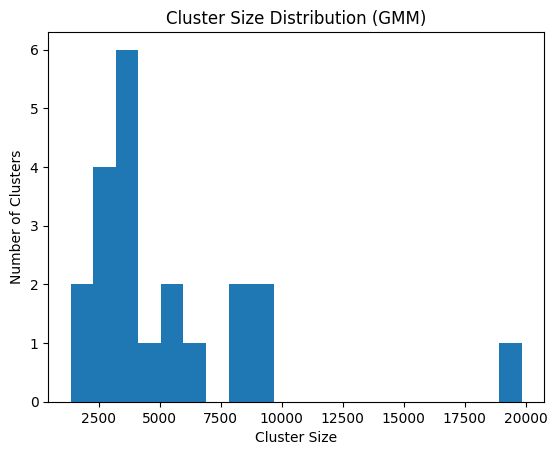

In [51]:
cluster_sizes.plot(kind='hist', bins=20)
plt.title("Cluster Size Distribution (GMM)")
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
plot_path = r"D:\4999 Data\plots\cluster_size_distribution"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

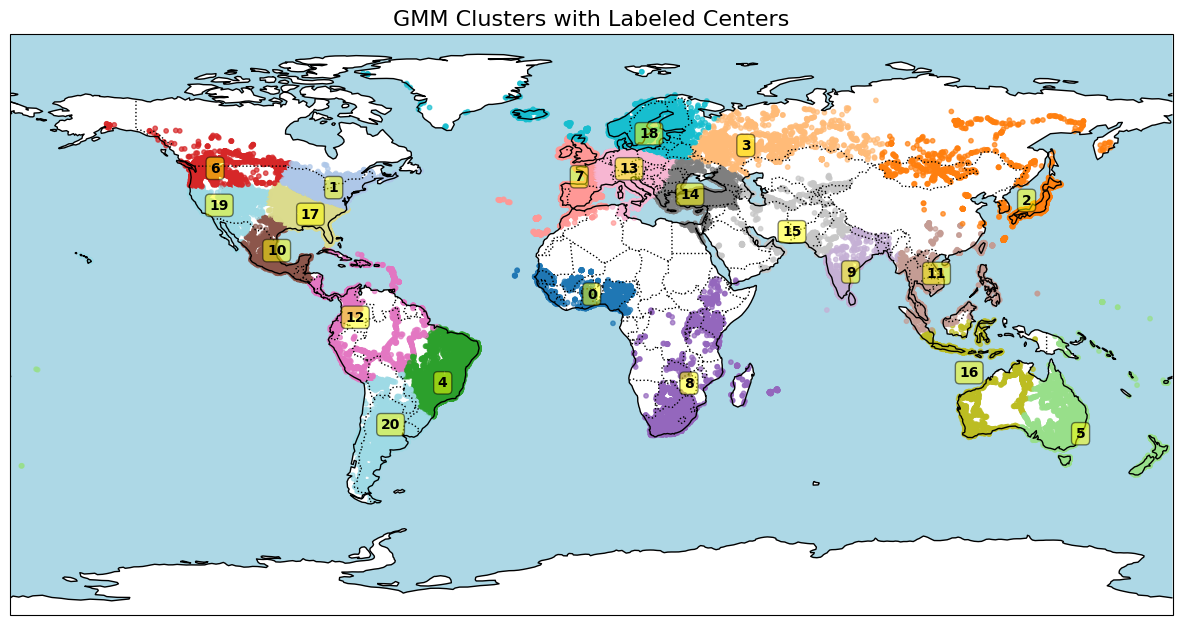

In [82]:
# Plot clusters on a map using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Scatter plot with color-coded clusters
scatter = ax.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='tab20',
                     s=10, alpha=0.7, transform=ccrs.PlateCarree())

# Annotate the center of each cluster
cluster_centers = df.groupby('cluster')[['longitude', 'latitude']].mean()

for cluster_id, row in cluster_centers.iterrows():
    ax.text(row['longitude'], row['latitude'], str(cluster_id),
            transform=ccrs.PlateCarree(),
            fontsize=10, weight='bold', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))

plt.title("GMM Clusters with Labeled Centers", fontsize=16)
plot_path = r"D:\4999 Data\plots\cluster_map_distribution"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

In [39]:
# Check cluster separation quality
silhouette = silhouette_score(coords_3d, gmm_labels)
print(f"Silhouette Score: {silhouette:.2f} (>-0.5 is okay)")

Silhouette Score: 0.42 (>-0.5 is okay)


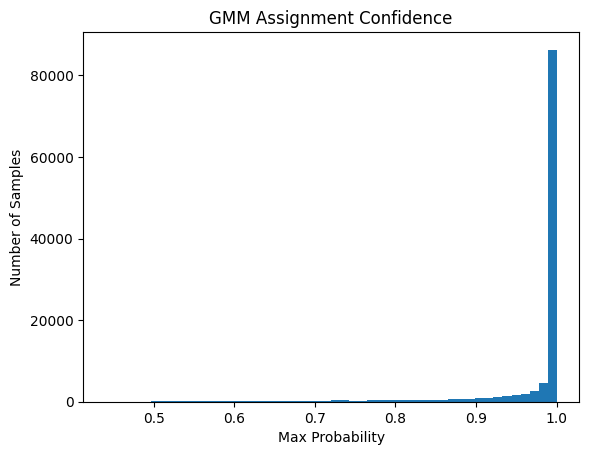

In [42]:
probs = gmm.predict_proba(coords_3d)
max_probs = probs.max(axis=1)

plt.hist(max_probs, bins=50)
plt.title("GMM Assignment Confidence")
plt.xlabel("Max Probability")
plt.ylabel("Number of Samples")
plt.show()

In [45]:
output_path = r"D:\4999 Data\combined_clustered.csv"
df.to_csv(output_path, index=False)

In [61]:
# Under-sample majority class(es)
max_per_cluster = 9000
samples = []

# Loop over each group and sample
for cluster_id, group in df.groupby('cluster'):
    sampled = group.sample(n=min(len(group), max_per_cluster), random_state=42)
    samples.append(sampled)

# Concatenate sampled groups back into one DataFrame
df_balanced = pd.concat(samples).reset_index(drop=True)

df_balanced.to_csv(r"D:\4999 Data\cluster_balanced.csv", index=False)

In [81]:
balanced_cluster_counts = df_balanced['cluster'].value_counts().sort_index()
print(balanced_cluster_counts)

cluster
0     2651
1     9000
2     5129
3     4015
4     3837
5     5031
6     3125
7     9000
8     3793
9     1525
10    2506
11    3792
12    2497
13    9000
14    5582
15    3257
16    1353
17    8220
18    8541
19    6366
20    3429
Name: count, dtype: int64


In [62]:
cluster_sizes = df_balanced['cluster'].value_counts()
print(cluster_sizes.describe())

count      21.000000
mean     4840.428571
std      2551.806626
min      1353.000000
25%      3125.000000
50%      3837.000000
75%      6366.000000
max      9000.000000
Name: count, dtype: float64


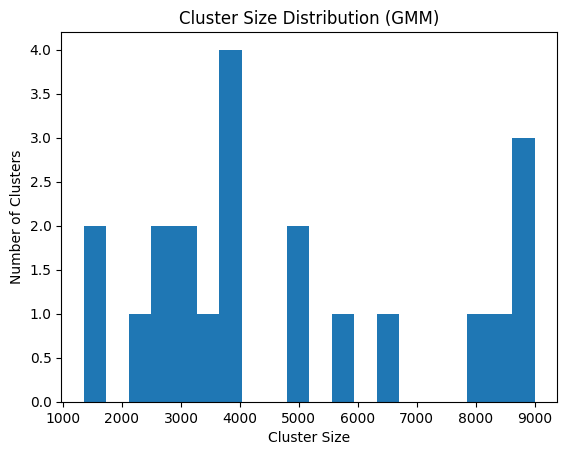

In [63]:
cluster_sizes.plot(kind='hist', bins=20)
plt.title("Cluster Size Distribution (GMM)")
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
plot_path = r"D:\4999 Data\plots\cluster_size_distribution"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

In [65]:
test_df = pd.read_csv(r"D:\4999 Data\test_lat_long.csv")
test_3d = to_cartesian(test_df['latitude'].values, test_df['longitude'].values)

In [73]:
test_labels = gmm.predict(test_3d)
test_df['cluster'] = test_labels
print(test_df.head())

                                          id   latitude   longitude  cluster
0  D:\4999 Data\test\00\1006398440000844.jpg  37.956651   14.954485       13
1  D:\4999 Data\test\00\2943891539215481.jpg  12.373333   -8.909906        0
2   D:\4999 Data\test\00\122945119799579.jpg   7.510295   99.061884       11
3  D:\4999 Data\test\00\5110173605711044.jpg -20.757287  164.451329        5
4   D:\4999 Data\test\00\178472887494234.jpg -26.391202  -70.688600       20


In [74]:
test_cluster_counts = test_df['cluster'].value_counts().sort_index()
print(test_cluster_counts)

cluster
0     2110
1     1968
2     1728
3     2814
4     1919
5     3385
6     2608
7     2047
8     5387
9     1506
10    1665
11    3105
12    2217
13    1950
14    2328
15    3295
16    1220
17    1577
18    3099
19    1643
20    2429
Name: count, dtype: int64


In [75]:
test_cluster_sizes = test_df['cluster'].value_counts()
print(test_cluster_sizes.describe())

count      21.000000
mean     2380.952381
std       927.054932
min      1220.000000
25%      1728.000000
50%      2110.000000
75%      2814.000000
max      5387.000000
Name: count, dtype: float64


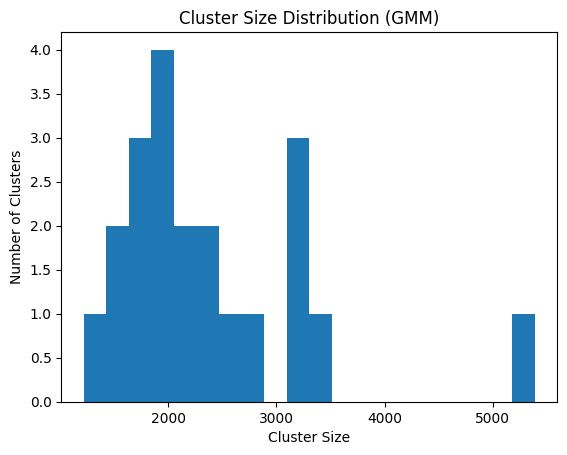

In [77]:
test_cluster_sizes.plot(kind='hist', bins=20)
plt.title("Cluster Size Distribution (GMM)")
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
plot_path = r"D:\4999 Data\plots\cluster_size_distribution"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

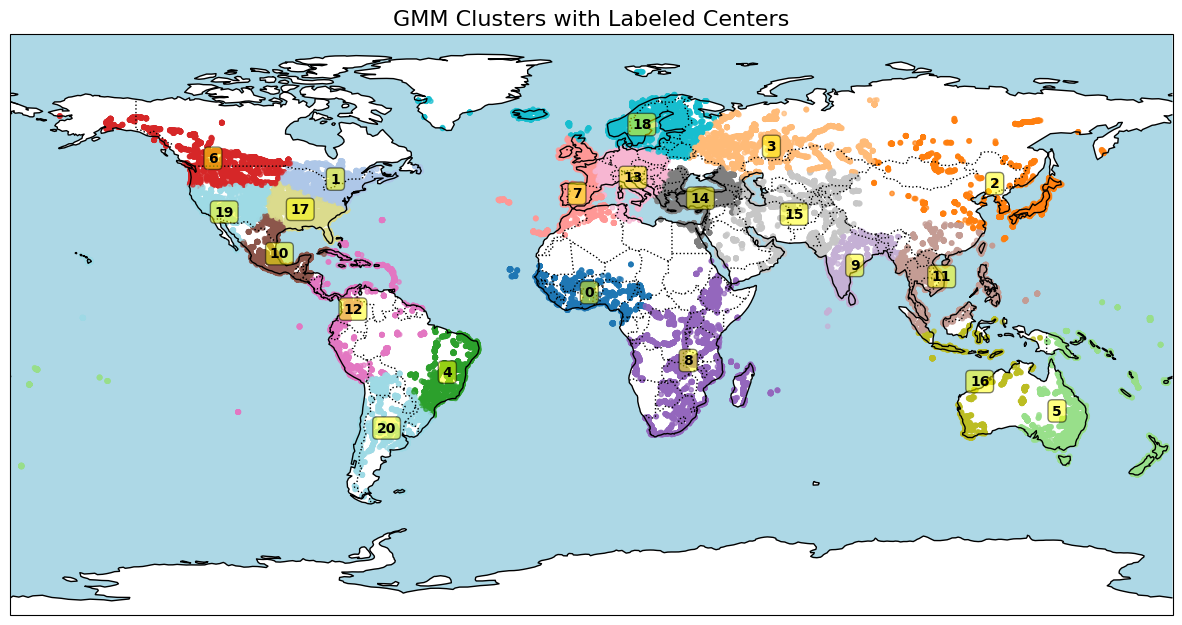

In [83]:
# Plot clusters on a map using Cartopy
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Scatter plot with color-coded clusters
scatter = ax.scatter(test_df['longitude'], test_df['latitude'], c=test_df['cluster'], cmap='tab20',
                     s=10, alpha=0.7, transform=ccrs.PlateCarree())

# Annotate the center of each cluster
cluster_centers = test_df.groupby('cluster')[['longitude', 'latitude']].mean()

for cluster_id, row in cluster_centers.iterrows():
    ax.text(row['longitude'], row['latitude'], str(cluster_id),
            transform=ccrs.PlateCarree(),
            fontsize=10, weight='bold', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))

plt.title("GMM Clusters with Labeled Centers", fontsize=16)
plot_path = r"D:\4999 Data\plots\test_cluster_map_distribution"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

In [80]:
output_path = r"D:\4999 Data\test_clustered.csv"
test_df.to_csv(output_path, index=False)